In [49]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import impulse, lti, step, butter, lfilter, welch
import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.arima.model import ARIMA

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

# Import data

In [50]:
df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# Plot raw data

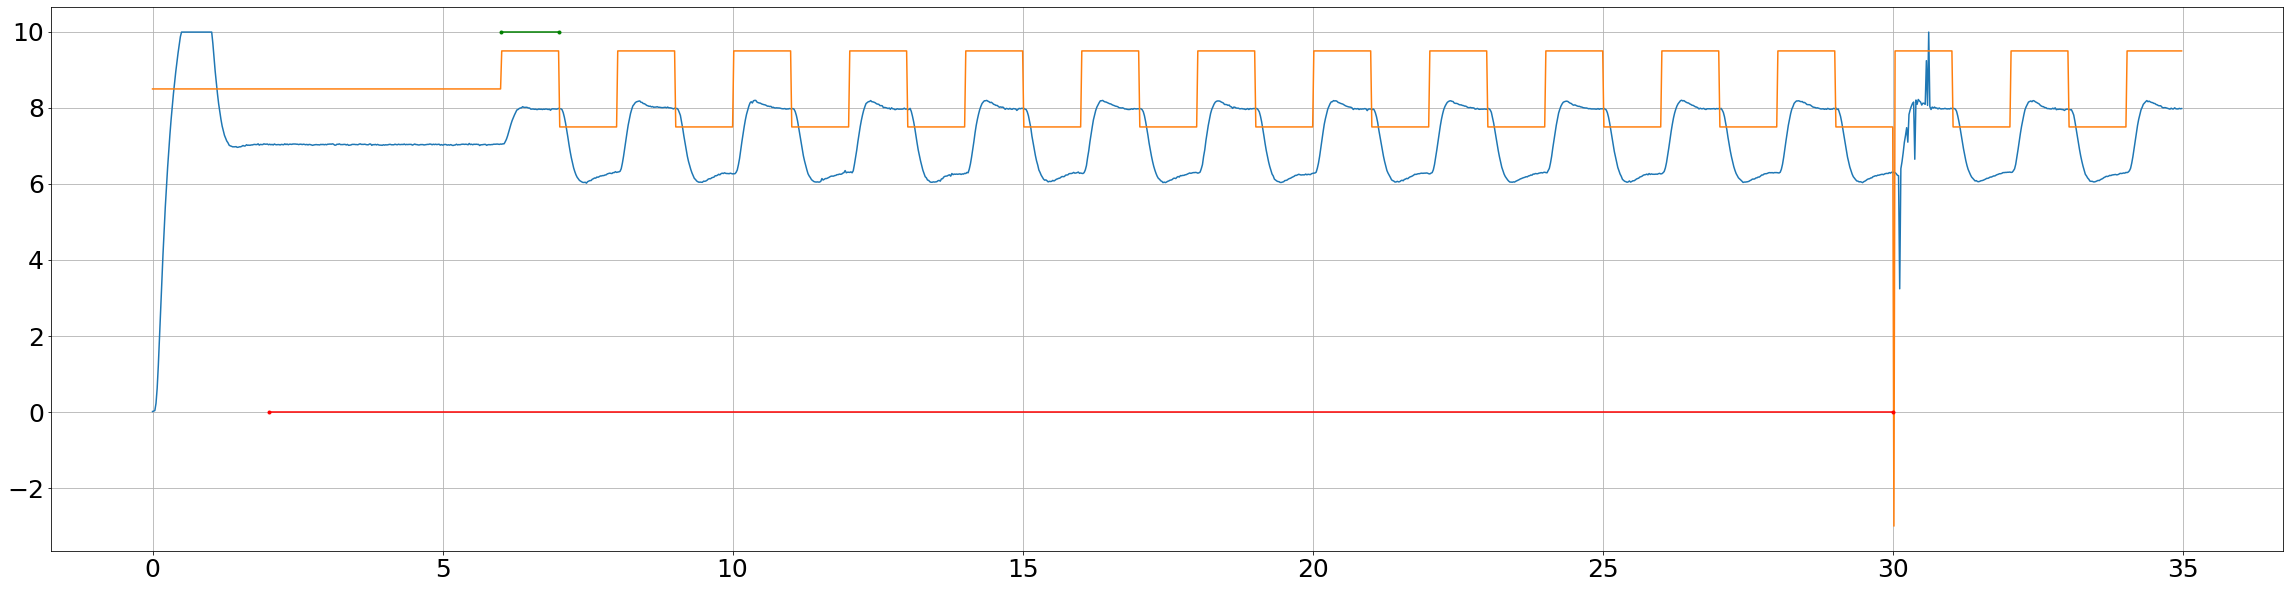

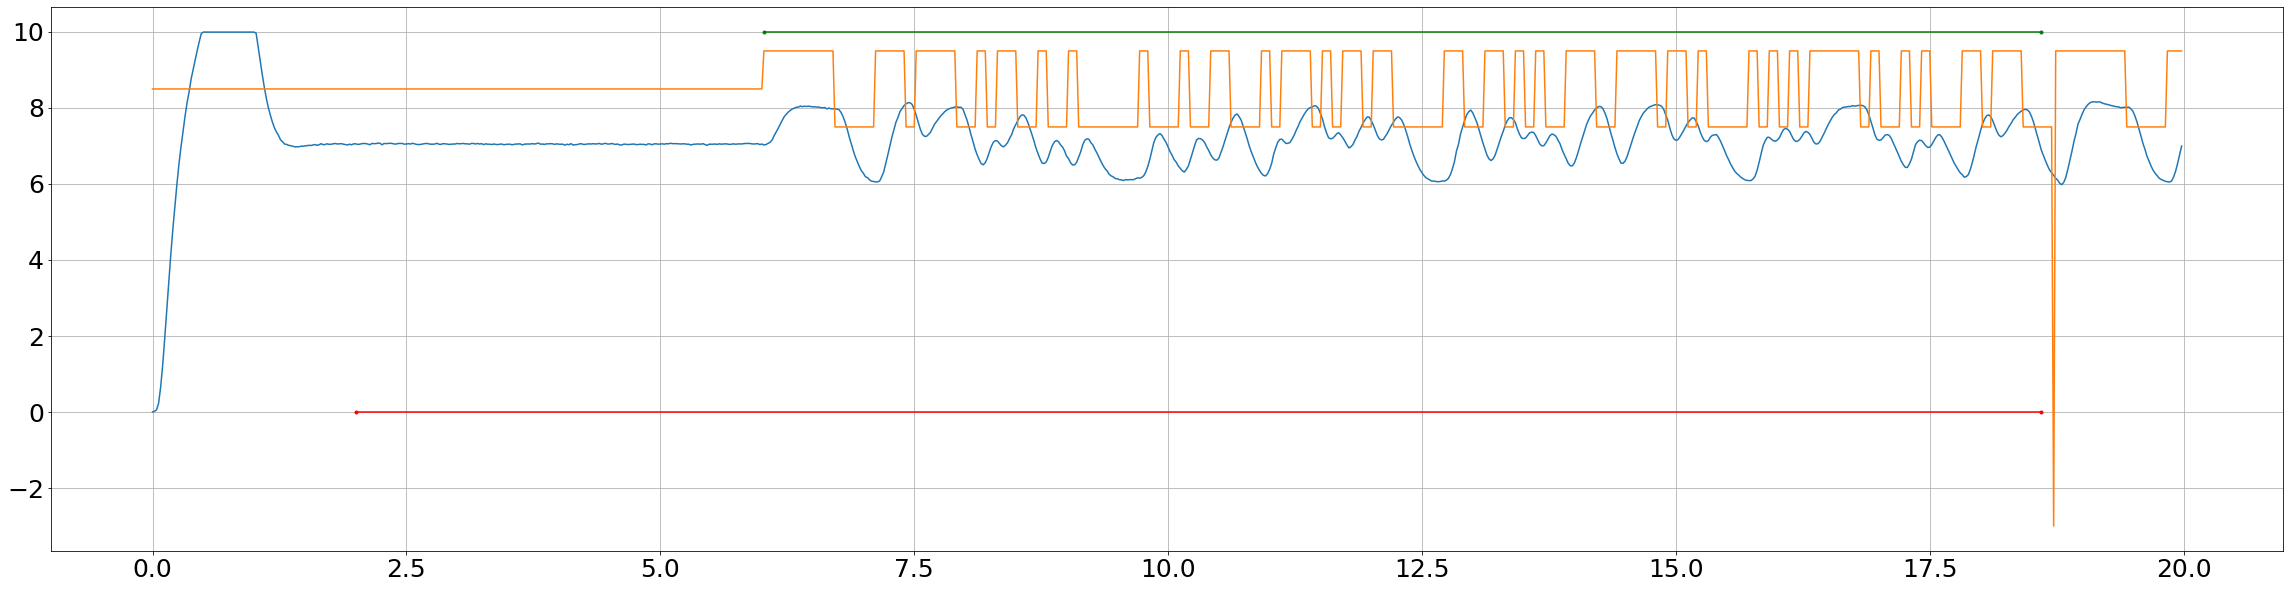

In [51]:
plt.figure(figsize=(40,10))
plt.plot(df1['time'],df1['y'])
plt.plot(df1['time'],df1['u'])
plt.plot([df1['time'][100],df1['time'][1500]],[0,0],'r', marker='.')
plt.plot([df1['time'][300],df1['time'][350]],[10,10],'g', marker='.')
plt.grid(True)
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df2['time'],df2['y'])
plt.plot(df2['time'],df2['u'])
plt.plot([df2['time'][100],df2['time'][930]],[0,0],'r', marker='.')
plt.plot([df2['time'][301],df2['time'][930]],[10,10],'g', marker='.')
plt.grid(True)
plt.show()

# Reformat data
## (Cut and z-normalize)

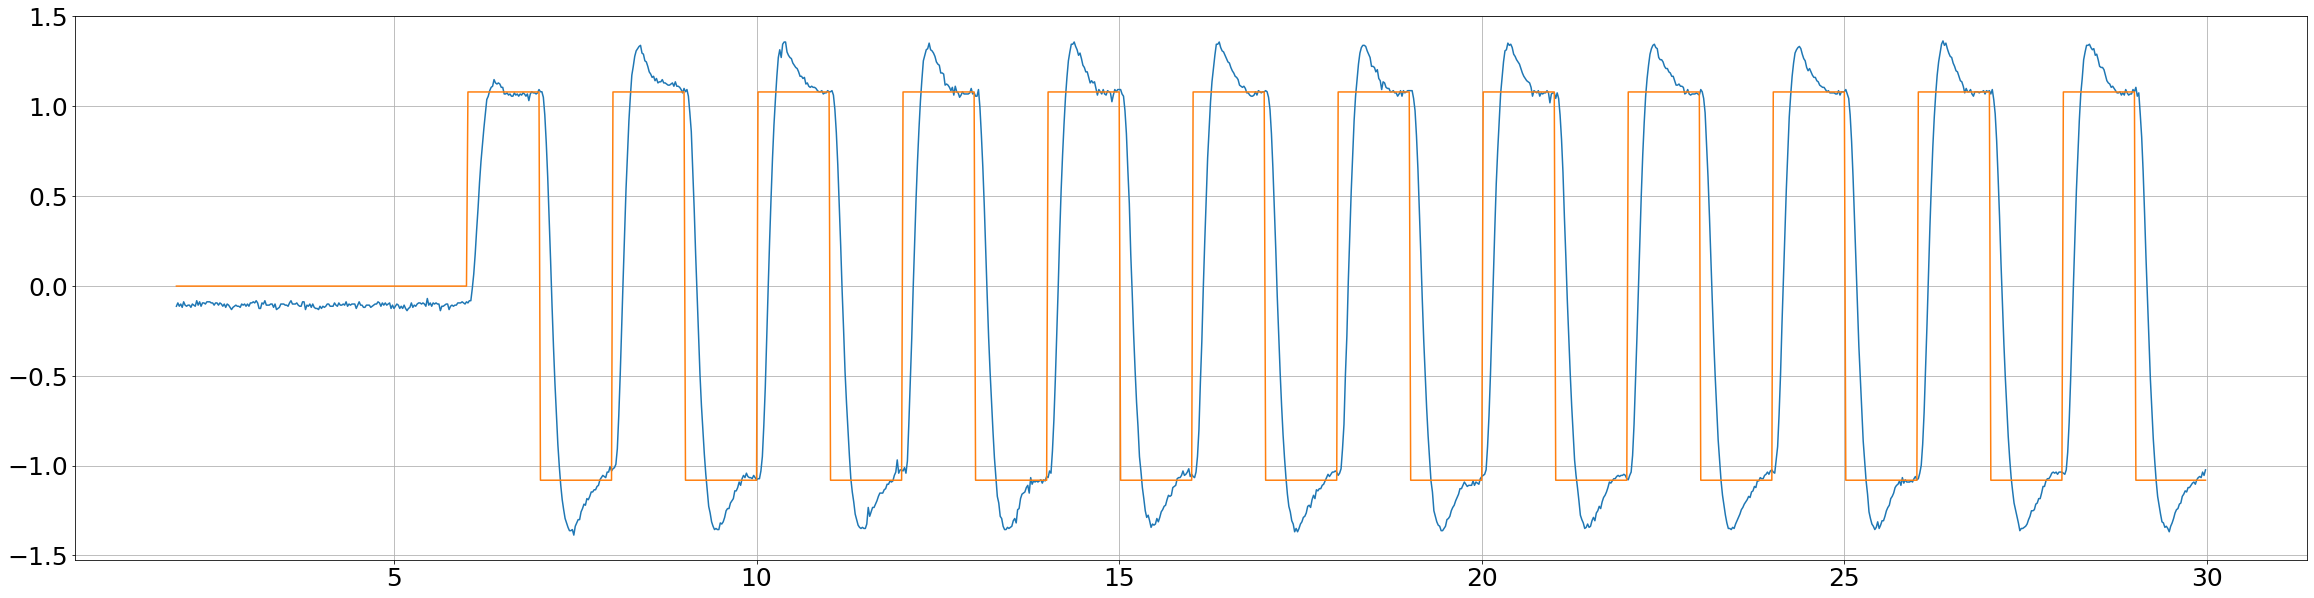

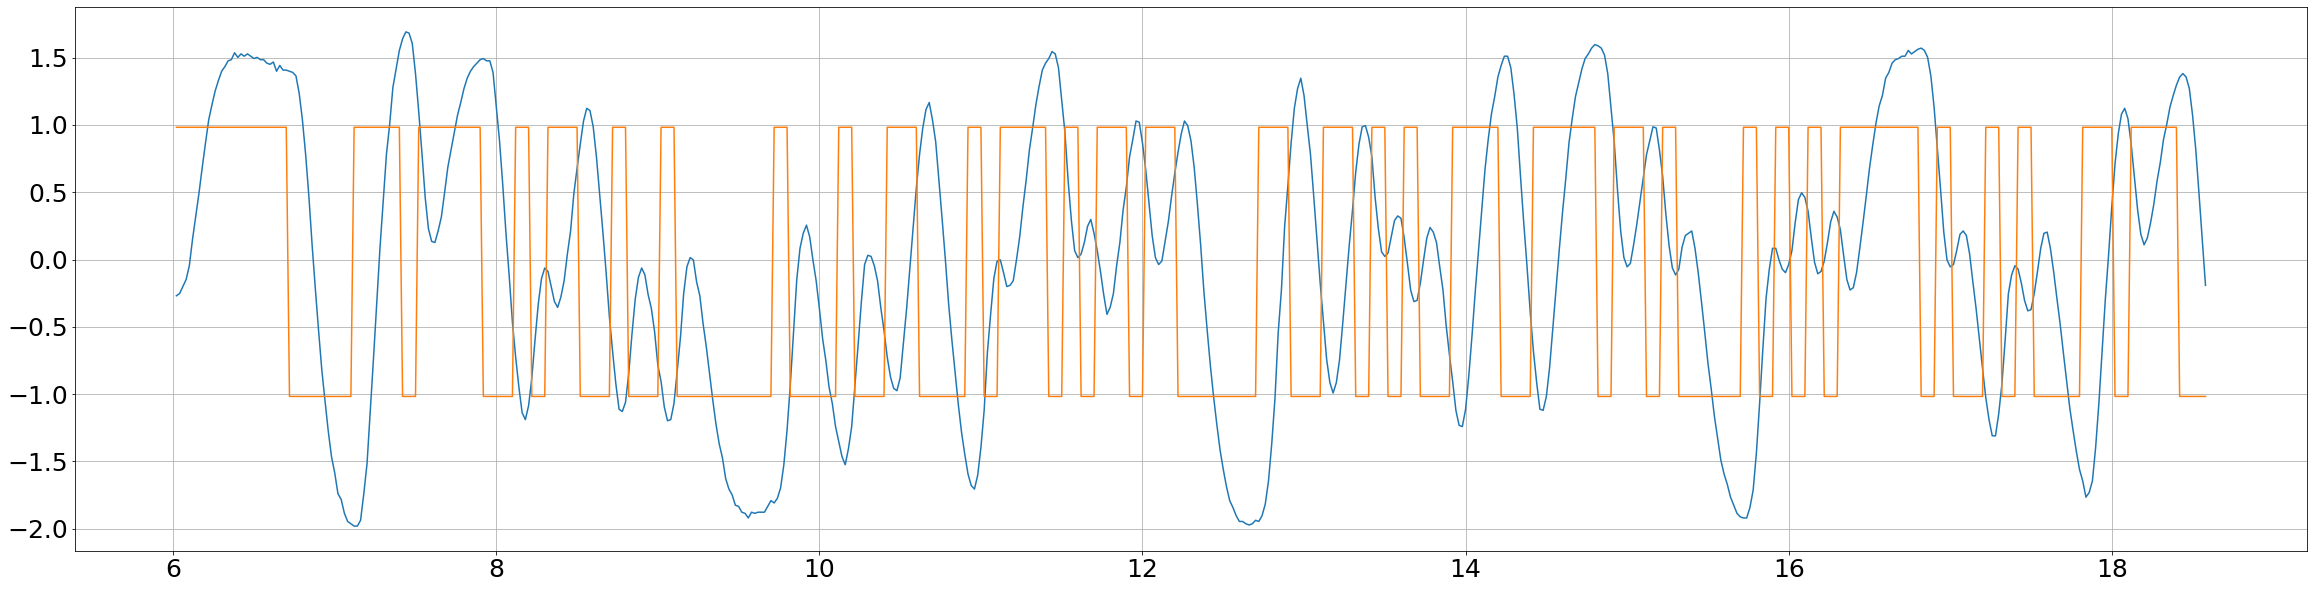

In [52]:
# z-normalize the signals
def z(x):
    x = np.asarray(x)
    return (x-np.average(x)) / np.std(x)

# cut
df1 = df1.iloc[100:1500]
df2 = df2.iloc[301:930]

# z-normalise
df1['u'] = z(df1['u'])
df1['y'] = z(df1['y'])
df2['u'] = z(df2['u'])
df2['y'] = z(df2['y'])

plt.figure(figsize=(40,10))
plt.plot(df1['time'],df1['y'])
plt.plot(df1['time'],df1['u'])
plt.grid(True)
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df2['time'],df2['y'])
plt.plot(df2['time'],df2['u'])
plt.grid(True)
plt.show()

# Fourier space (of PRBS)

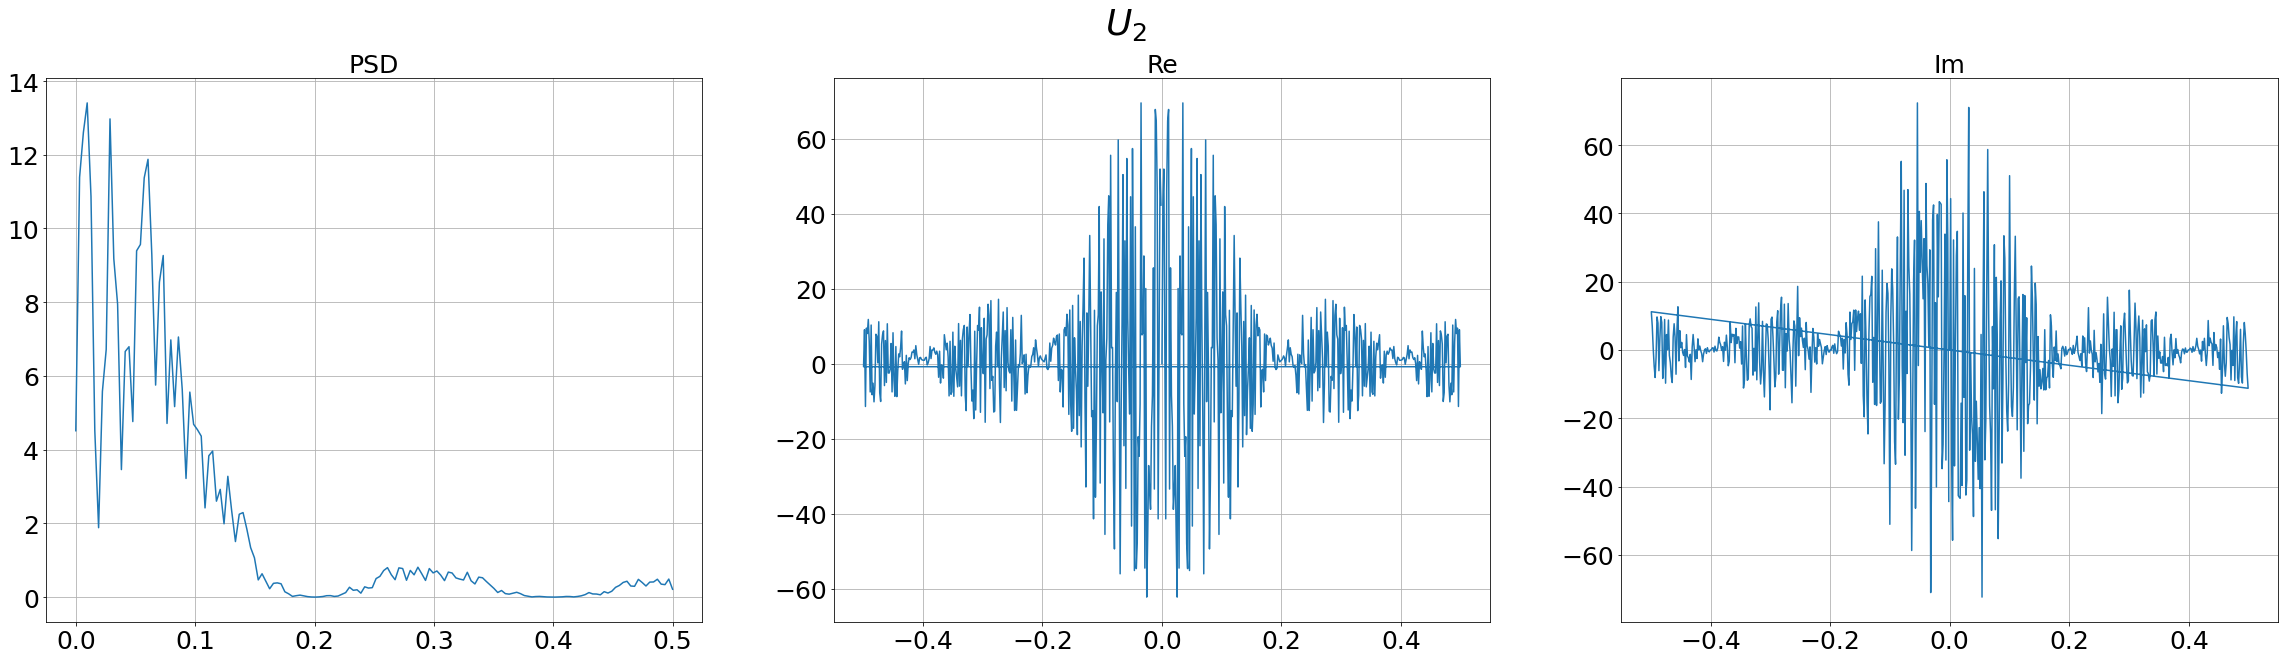

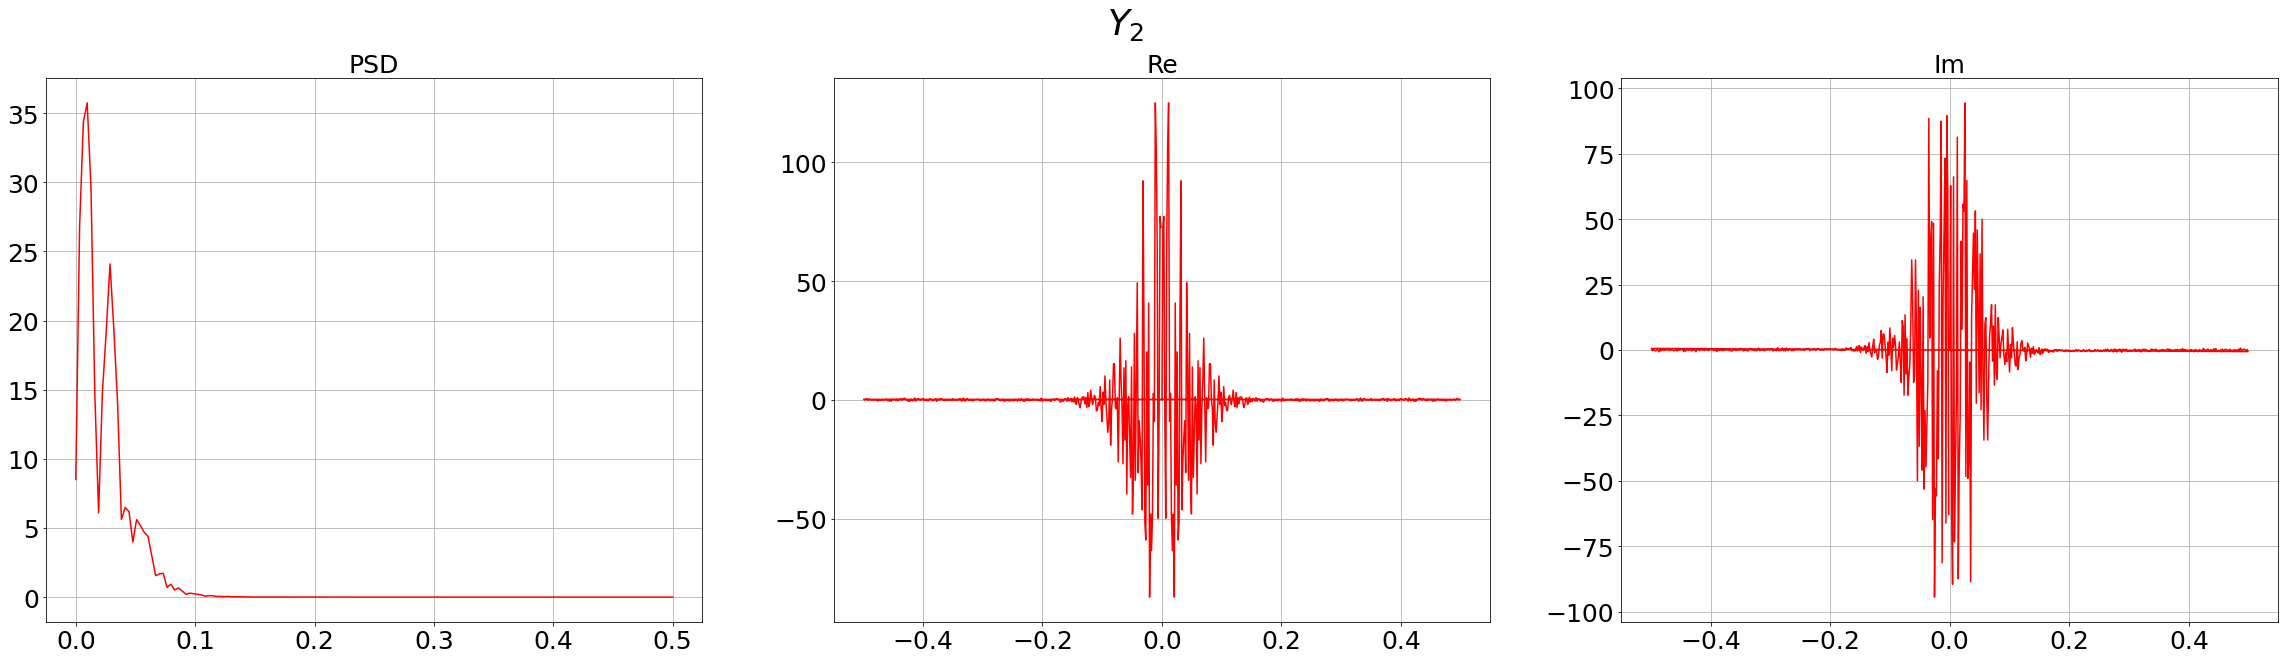

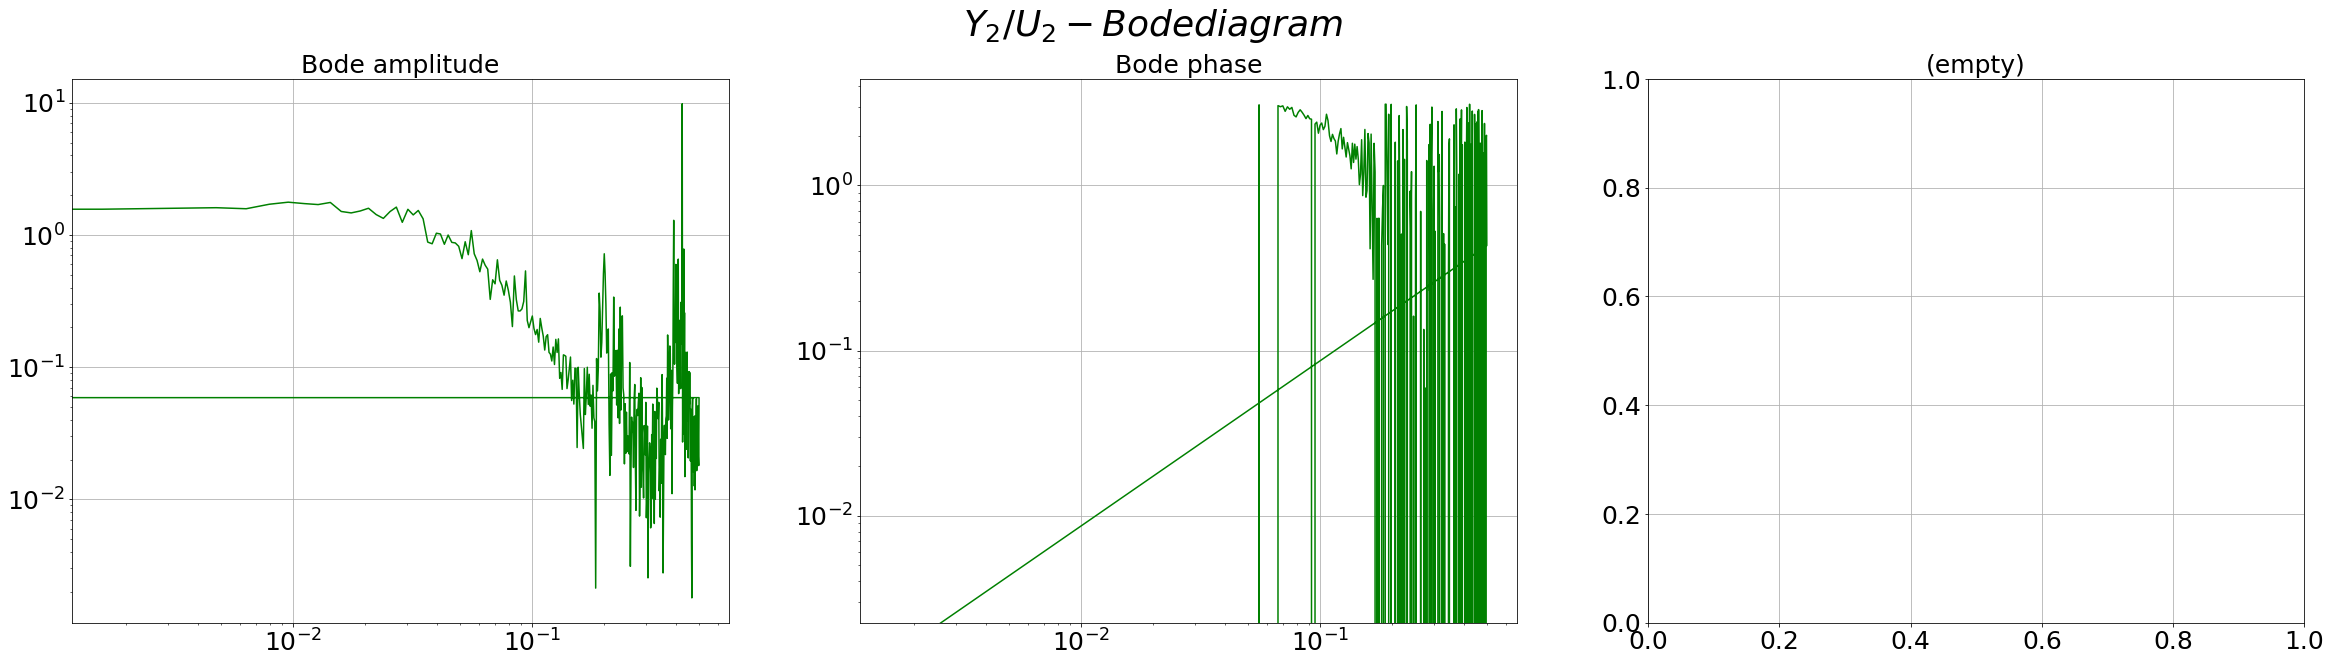

In [53]:
fs = 1 # define sampling frequency to be 1
freqs = np.fft.fftfreq(len(df2['u']), 1)

fig, axn = plt.subplots(1,3,figsize=(40,10))
fig.suptitle(r'$U_2$')
f, psd_u = welch(df2['u'], fs, nperseg=len(df2['u'])//2)
ft_u = np.fft.fft(df2['u'])
axn[0].plot(f, psd_u)
axn[1].plot(freqs, np.real(ft_u))
axn[2].plot(freqs, np.imag(ft_u))
axn[0].set_title('PSD')
axn[1].set_title('Re')
axn[2].set_title('Im')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
plt.show()

fig, axn = plt.subplots(1,3,figsize=(40,10))
fig.suptitle(r'$Y_2$')
f, psd_y = welch(df2['y'], fs, nperseg=len(df2['y'])//2)
ft_y = np.fft.fft(df2['y'])
axn[0].plot(f, psd_y, c='r')
axn[1].plot(freqs, np.real(ft_y), c='r')
axn[2].plot(freqs, np.imag(ft_y), c='r')
axn[0].set_title('PSD')
axn[1].set_title('Re')
axn[2].set_title('Im')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
plt.show()

fig, axn = plt.subplots(1,3,figsize=(40,10))
fig.suptitle(r'$Y_2/U_2 - Bode diagram$')
ft_G = ft_y / ft_u
axn[0].loglog(freqs, np.abs(ft_G), c='g')
axn[1].loglog(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[2].set_title('(empty)')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
plt.show()

# PRELIMINARY ESTIMATION

## Compute step response function (transfer function)

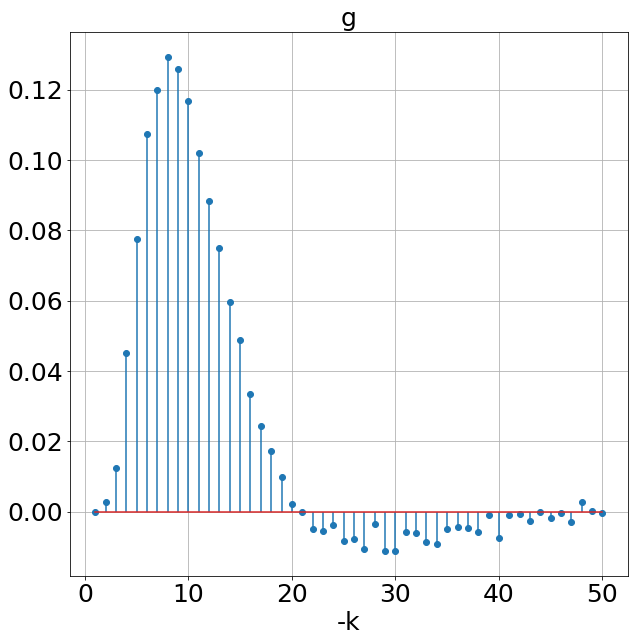

In [54]:
u1_set = list(set(df1['u']))
if len(u1_set) != 3:
    raise ValueError('len not equal 3')

u1_max = np.max(u1_set)
u1_med = np.median(u1_set)
u1_min = np.min(u1_set)

u1_bin = []
for i in df1['u']:
    if i == u1_max: u1_bin.append(1)
    if i == u1_med: u1_bin.append(0)
    if i == u1_min: u1_bin.append(-1)

# Find the locations of the rising edges in the input
rising_indices = np.where(np.diff(u1_bin) == 2)[0] + 1
falling_indices = np.where(np.diff(u1_bin) == -2)[0] + 1

impulse_responses_rising = np.asarray([df1['y'][i:i+50] for i in rising_indices][1:]) # exclude the first one because different (starting from zero)
impulse_responses_falling = np.asarray([-df1['y'][i:i+50] for i in falling_indices][:-1]) # exclude the last one because it is shorter
impulse_responses = np.vstack([impulse_responses_rising,impulse_responses_falling])

# # plot all responses
# for c, i in enumerate(impulse_responses):
#     plt.plot(np.arange(1,51),i)
#     print(c)
#     plt.show()
# delete a response that does not look right
impulse_responses = np.delete(impulse_responses,10,axis=0)

# average responses (we only care about the gradient (except for g_0)
impulse_response = (np.mean(impulse_responses, axis=0))

# works better if we set it to zero rather than to np.mean(impulse_responses_rising, axis=0)[0] / 2
g = [0]

for i in range(1, len(impulse_response)):
    g.append((impulse_response[i]-impulse_response[i-1])/2) # /2 cuz steps size=2 (from -1 to 1)

# Plotting the Impulse Response
fig, axn = plt.subplots(1,1,figsize=(10,10))
plt.stem(np.arange(1,51),g)
plt.title('g')
plt.xlabel('-k')
plt.grid(True)
plt.show()

## Reconstruct output signal from the step response function

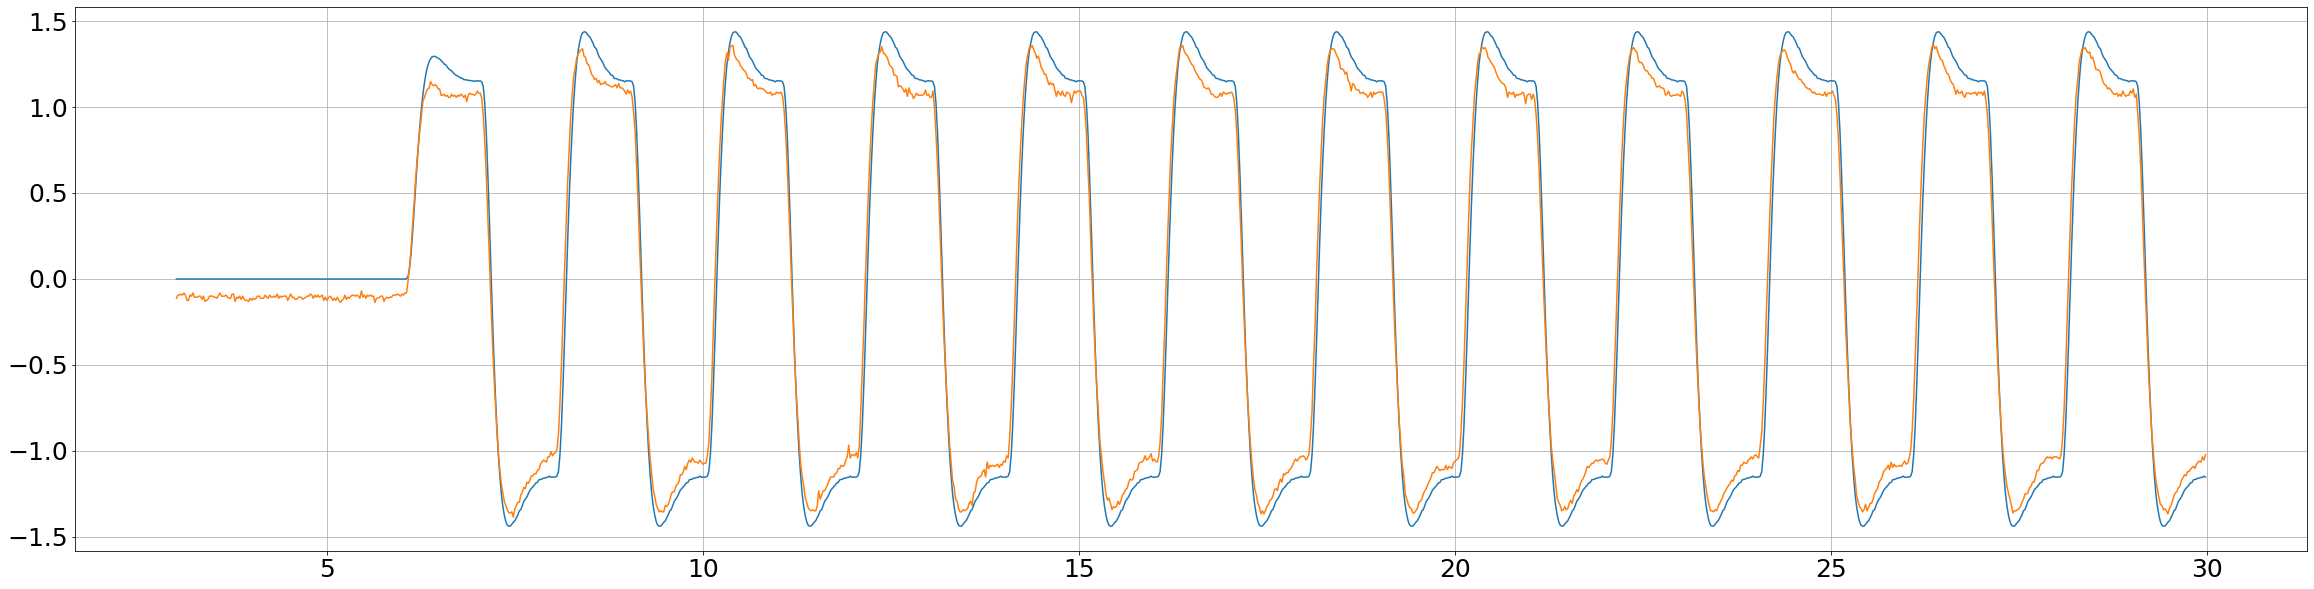

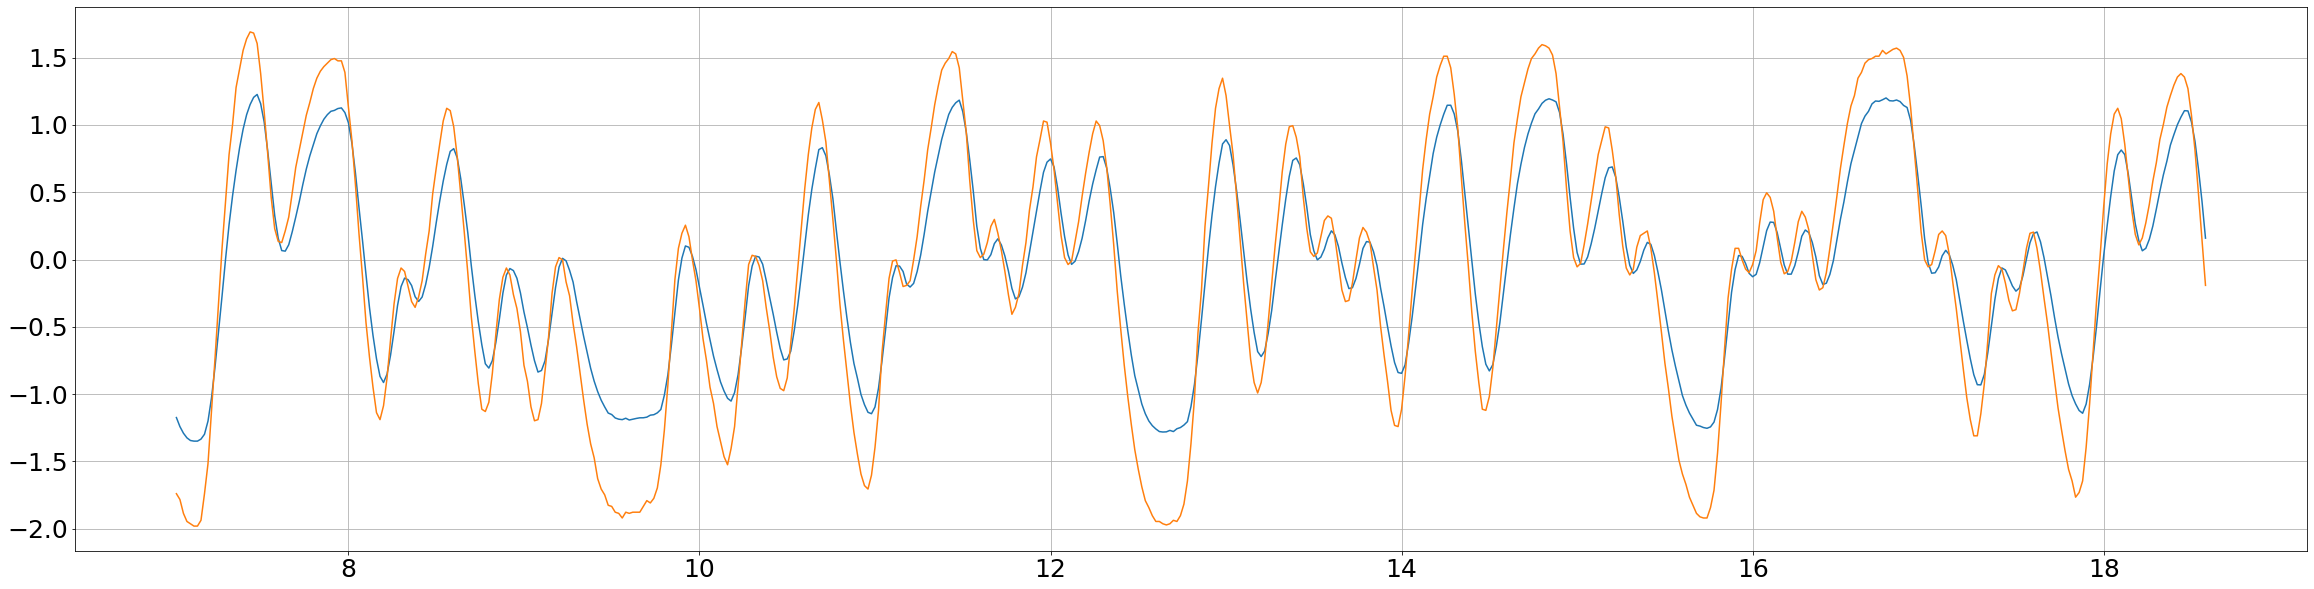

In [55]:
# for train of pulses
y_rec = np.zeros(len(df1['u'])-50) # y reconstructed

g_rev = g[::-1] # step response function reversed

for i in range(len(df1['y'])-50):
    y_rec[i] = np.sum(g_rev * df1['u'][i:i+50])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df1['time'][50:], y_rec)
plt.plot(df1['time'][50:], df1['y'][50:])
plt.grid(True)
plt.show()

#----------------------------------------------

#for PRBS
y_rec = np.zeros(len(df2['u'])-50) # y reconstructed

g_rev = g[::-1] # step response function reversed

for i in range(len(df2['y'])-50):
    y_rec[i] = np.sum(g_rev * df2['u'][i:i+50])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df2['time'][50:], y_rec)
plt.plot(df2['time'][50:], df2['y'][50:])
plt.grid(True)
plt.show()

The step response (transfer function) manages to capture the shape of the response for the train of pulses input signal. However, the value deviate quite a bit

# Estimate transfer function from corrrelation function (Ljung, pg. 170)

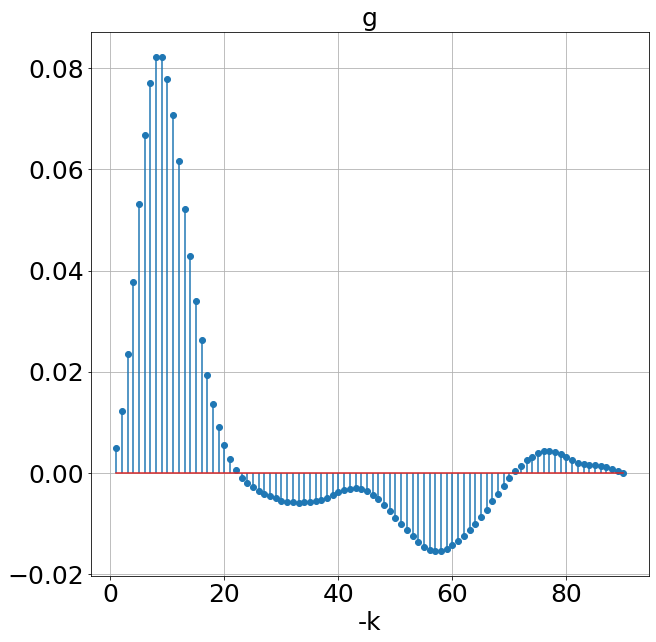

In [56]:
m = np.sum([1 for i in df2['u'] if i==np.max(list(set(df2['u'])))])
M = 90 # of delays
N = M # to be able to easy invert the matrix equation

def Rab(a,b):
    a, b = np.asarray(a), np.asarray((b))
    if len(a) != len(b): raise ValueError
    N = len(a)
    Ryu = np.zeros(N)
    for tau in range(N):
        c = 0
        for k in range(N-tau):
            c += a[k+tau] * b[k]
        Ryu[tau] = 1 / (N-tau) * c
    return Ryu

Ryu = Rab(df2['y'],df2['u'])
Ru = Rab(df2['u'],df2['u'])

Ryu = Ryu[:N]
Ru_mat = np.ones((N,M)) * m * (m-1) / (N * (N-1))
for mi in range(M-1):
    Ru_mat[mi,mi+1] *= (N-1) / (m-1)

#np.set_printoptions(threshold=np.inf)

g = np.linalg.solve(Ru_mat,Ryu)

# tweaks (don't understand why it works (also looks) better if I do this). Maybe a bug in the code
g[0] = 0.00
g = - (g)
g = np.roll(g,-1)

# Plotting the Impulse Response
fig, axn = plt.subplots(1,1,figsize=(10,10))
plt.stem(np.arange(1,M+1),g)
plt.title('g')
plt.xlabel('-k')
plt.grid(True)
plt.show()

# Reconstruct output signal from the ('correlation') response function

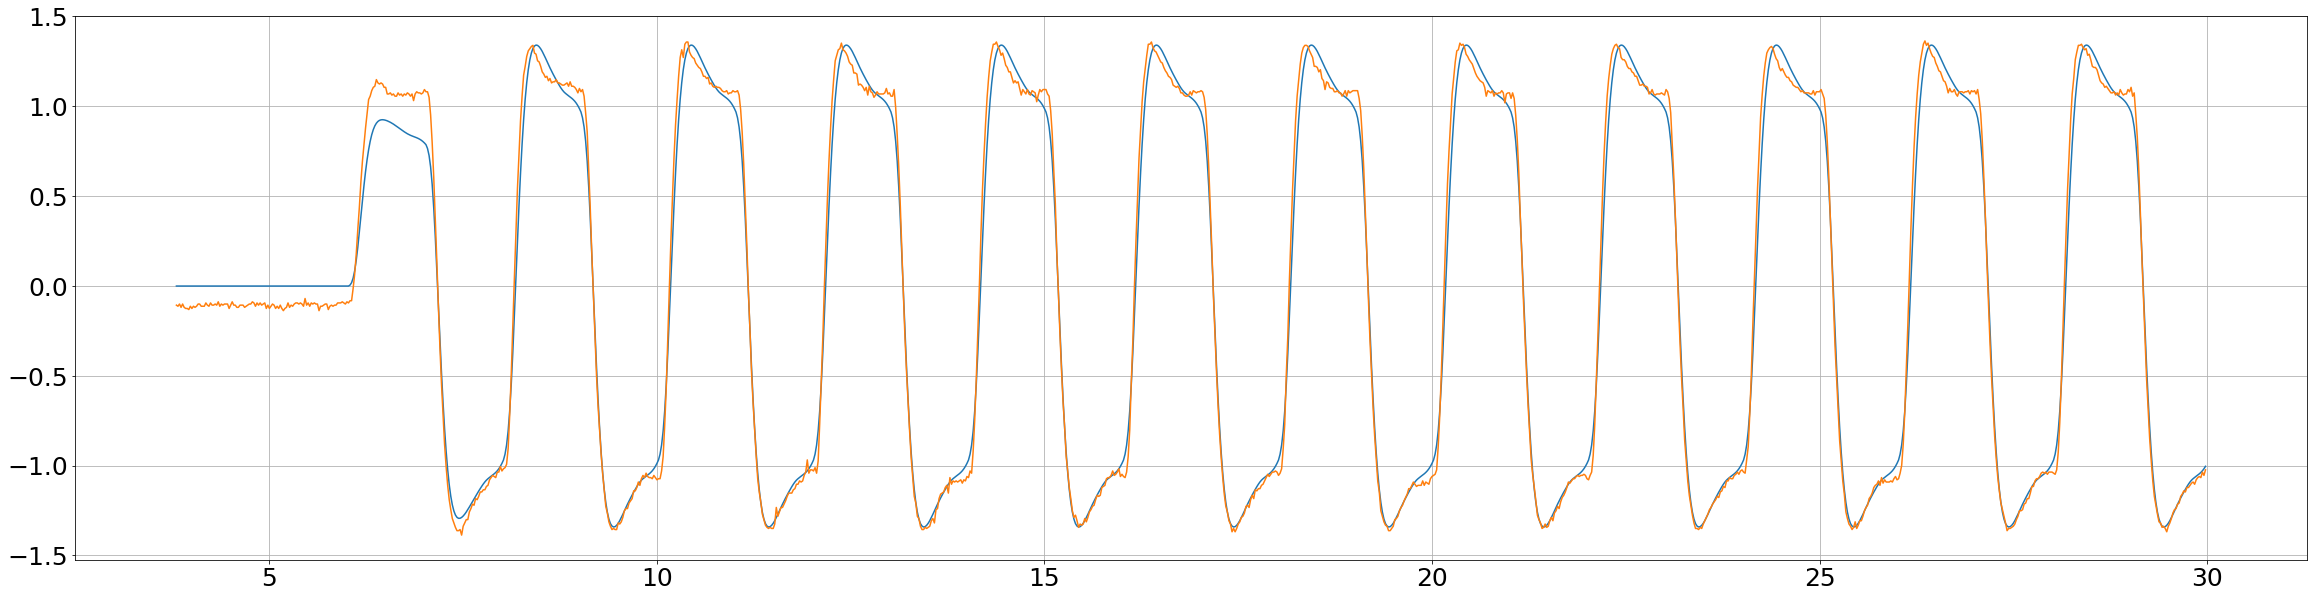

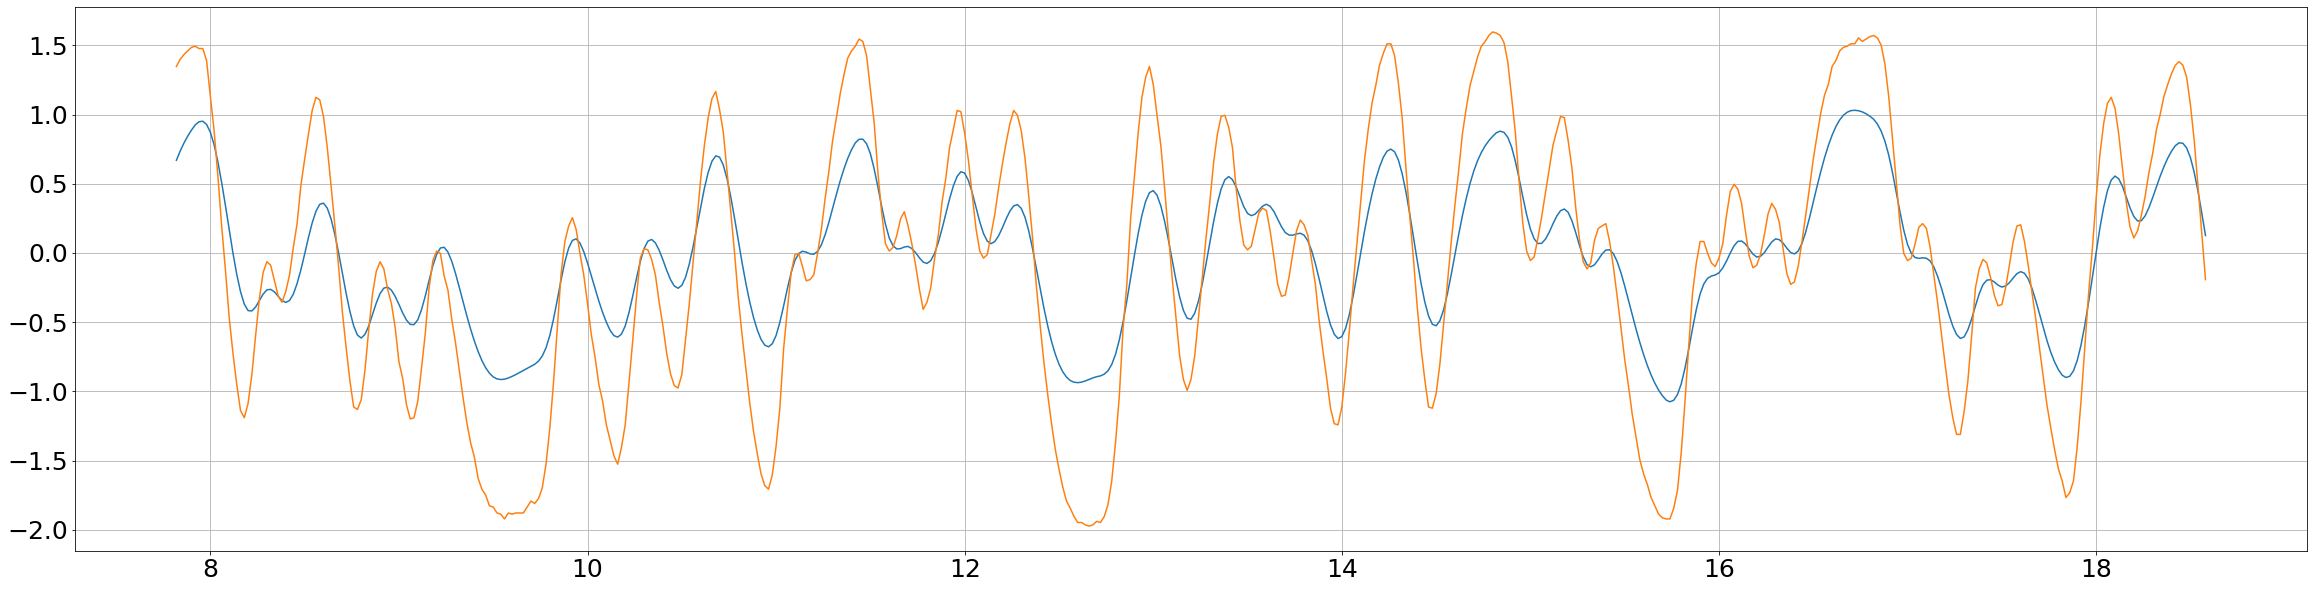

In [57]:
g_rev = g[::-1] # step response function

#----------------------------------------------

# for train of pulses
y_rec = np.zeros(len(df1['u'])-M) # y reconstructed

for i in range(len(df1['y'])-M):
    y_rec[i] = np.sum(g_rev * df1['u'][i:i+M])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df1['time'][M:], y_rec)
plt.plot(df1['time'][M:], df1['y'][M:])
plt.grid(True)
plt.show()

#----------------------------------------------

#for PRBS
y_rec = np.zeros(len(df2['u'])-M) # y reconstructed

for i in range(len(df2['y'])-M):
    y_rec[i] = np.sum(g_rev * df2['u'][i:i+M])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df2['time'][M:], y_rec)
plt.plot(df2['time'][M:], df2['y'][M:])
plt.grid(True)
plt.show()

For the time delay of M=90 samples, the transfer function, reconstructed from the correlation functions $R_{\epsilon}$ and $R_{\epsilon,u}$, applied on the PRBS manages to capture the step response quite well, however, for the PRBS it performs worse than the transfer function obtained from the step response. For number of delays M=110, the mentioned transfer function captures PRBS 'quite well', but in return performs much worse on the train of pulses signal. For some reason, the first coefficient g(0) has to be set to zero for the transfer function to make sense (both for step and correlation case). For the transfer function g obtained from correlation functions, also g=-g must be applied (code bug?). It also works better if we make a transformation $g_i=g_{i+1}$ where $i$ is periodic under mod M.

# Preliminary estimation of the transfer function order (Ljung, pg. 496)

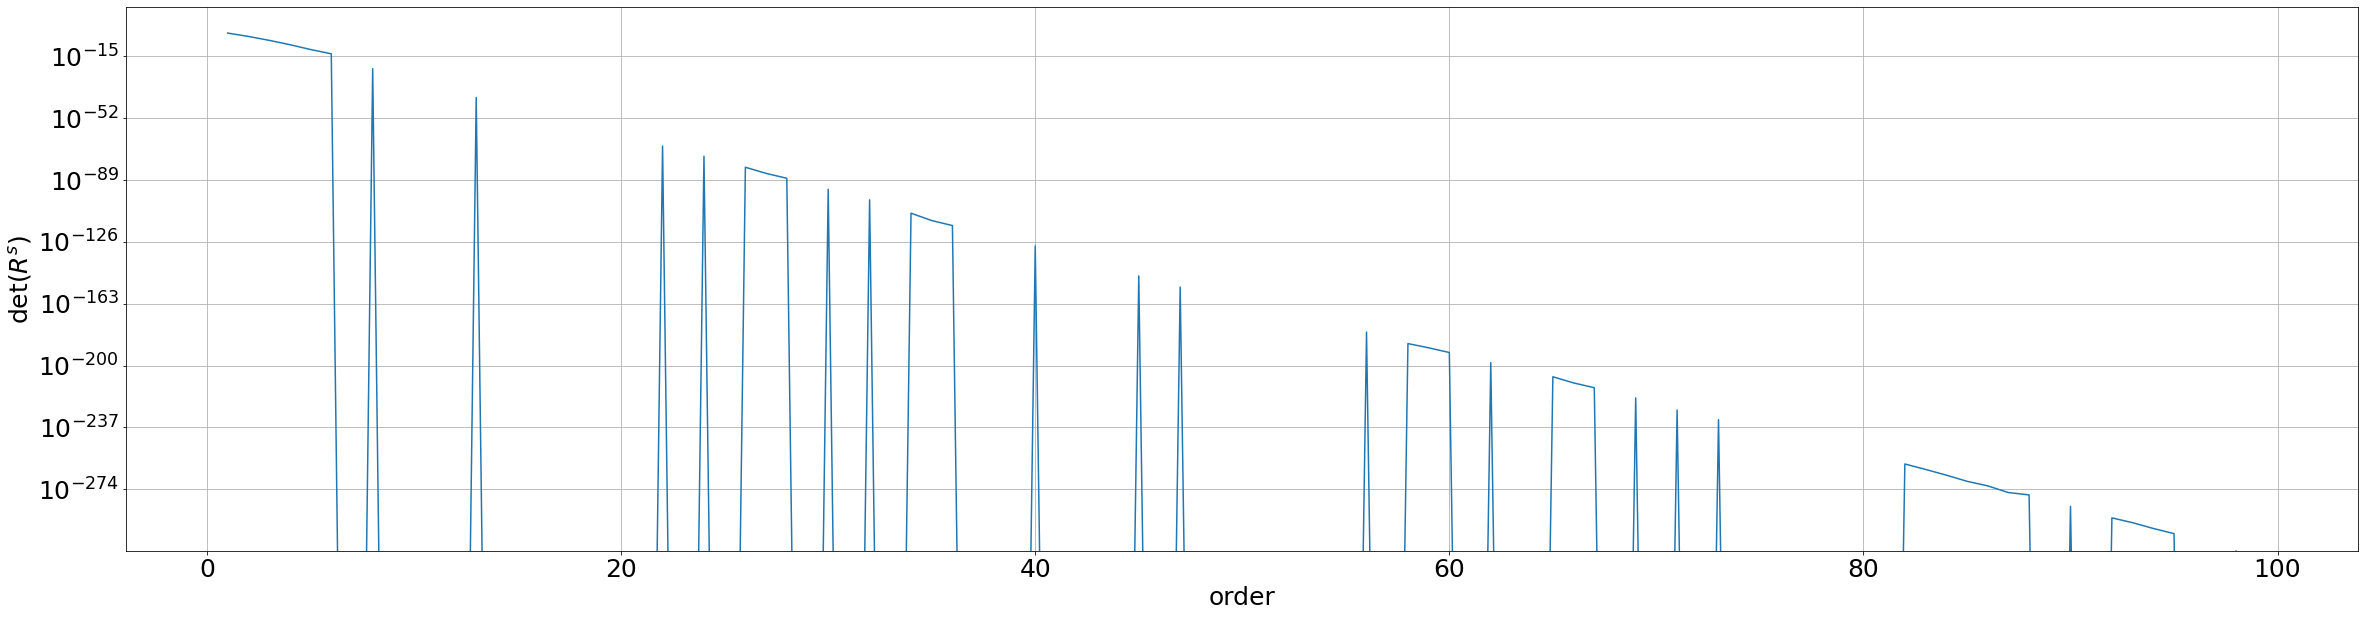

In [83]:
# The assuming no noise in the input:
# fi_s = [-y(t-1) ,..., -y(t-s), u(t-1) ,..., u(t-s)
# If n=true system order, then R^s=E[ fi_s * fi_s^T ] is non-singular for s<=n and singular for s>n

def check_order_nonoiseininput(df, ordmin, ordmax):

    def R_0(fiy,fiu):
        fi = np.concatenate((-np.asarray(fiy),np.asarray(fiu)))
        return np.outer(fi,fi)

    l = len(df['u'])
    det_R_s = []

    for ord in np.arange(ordmin,ordmax):

        R_s = np.zeros((2*ord,2*ord))

        for i in range(l - ord):

            fi = np.concatenate((-np.asarray(df['y'][i:i+ord][::-1]),np.asarray(df['u'][i:i+ord][::-1])))
            R_s += np.outer(fi,fi)

        R_s /= (l - ord)

        det_R_s.append(np.linalg.det(R_s))

    return np.arange(ordmin,ordmax), det_R_s

# For noise in the input the idea is similar

def check_order(df, ordmin, ordmax):

    l = len(df['u'])
    det_R_s = []

    for ord in np.arange(ordmin,ordmax):

        R_s = np.zeros((2*ord,2*ord))

        for i in range(l - 2 * ord):

            fi = np.concatenate((-np.asarray(df['y'])[i+ord:i+2*ord][::-1],np.asarray(df['u'])[i+ord:i+2*ord][::-1]))
            zeta = np.asarray(df['u'])[i:i+2*ord][::-1]

            R_s += np.outer(fi,zeta)

        R_s /= (l - 2*ord)

        det_R_s.append(np.linalg.det(R_s))

    return np.arange(ordmin,ordmax), det_R_s

x,y = check_order(df2, 1, 100)

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.semilogy(x,y)
plt.grid(True)
plt.xlabel('order')
plt.ylabel(r'det$(R^s)$')
plt.show()

There is no clear drop in the value of the determinant... no system order can be estimated via this procedure.

# AR(MA)X